In [39]:
import math
import torch

import gpytorch
import pyro
import pyro.distributions
import tqdm.notebook
import matplotlib.pyplot as plt


from scripts.Model import NeuroCluster

import pyro
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import torch.nn.utils.rnn as rnn
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
batch_size=10
intensity_max = 50
true_intensity_function = lambda times: torch.sin(times * 2 * math.pi).add(1).mul(intensity_max / 2.)

In [67]:
max_time = 2

times = torch.linspace(0, max_time, 128)
# num_samples = [int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item()) for _ in range(batch_size)]
fix = int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item())
num_samples = [fix for _ in range(batch_size)]
print(f"Number of sampled arrivals: {num_samples}")

Number of sampled arrivals: [54, 54, 54, 54, 54, 54, 54, 54, 54, 54]


In [68]:
def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res

arrival_times = [pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=log_prob_accept,
    log_scale=0.
)(torch.Size([sample_num])) for sample_num in num_samples]

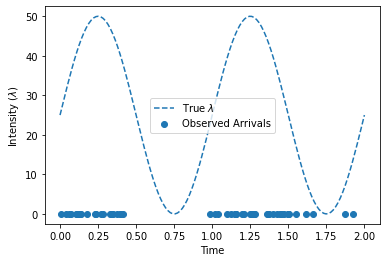

In [69]:
fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_function(times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times[2], torch.zeros_like(arrival_times[2]), label=r"Observed Arrivals")
ax.legend(loc="best")

In [83]:
padding_value = -1
#pad_seq = rnn.pad_sequence(arrival_times, padding_value=padding_value, batch_first=True)
pad_seq = rnn.pack_sequence(arrival_times)
print(pad_seq)
ave_arrivals = np.mean([data_i.numel() for data_i in arrival_times])

PackedSequence(data=tensor([1.0777, 0.4577, 1.3638, 1.3060, 1.2904, 1.8938, 0.2321, 0.0802, 1.3832,
        0.1162, 1.4171, 1.3613, 1.1245, 0.3314, 0.6156, 0.2244, 1.3165, 1.0907,
        1.1952, 0.3035, 1.3469, 1.1502, 0.1120, 1.2139, 0.0412, 0.5157, 0.3043,
        0.2288, 1.3958, 0.1870, 0.3690, 0.3338, 1.4490, 1.1308, 0.4491, 0.0344,
        1.1494, 1.2550, 0.4733, 0.5968, 1.3654, 0.0947, 0.1316, 1.1794, 1.3725,
        0.2638, 0.2702, 1.2645, 1.1982, 1.4702, 0.4196, 0.3871, 1.1485, 1.1612,
        1.3253, 1.3166, 0.1493, 0.0887, 0.0730, 1.2644, 1.9379, 0.3914, 1.3590,
        0.1685, 0.3543, 0.1054, 0.3621, 0.9767, 1.0000, 0.2202, 0.9922, 1.1912,
        1.4229, 0.3827, 0.0441, 0.0693, 1.3031, 0.2995, 1.3202, 1.5587, 1.3545,
        0.2476, 1.2646, 0.9952, 0.4176, 1.4897, 0.9182, 0.1019, 1.2650, 1.8664,
        1.5267, 1.2590, 0.2792, 1.9565, 0.2140, 0.8994, 1.6224, 1.2075, 1.5476,
        1.3353, 1.4687, 0.2895, 1.4568, 0.3276, 0.3315, 0.1719, 0.0930, 0.8713,
        0.0445, 0.35

In [89]:
model = NeuroCluster(ave_arrivals, max_time, class_num=4, num_inducing=64)

In [90]:
quadrature_times = torch.linspace(0, max_time, 64)


In [106]:
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 2
num_particles = 1 if smoke_test else 32


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(pad_seq, quadrature_times)
        loader.set_postfix(loss=loss)

train()

  0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'np' is not defined

In [65]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentile_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

ValueError: x and y must have same first dimension, but have shapes torch.Size([64]) and torch.Size([256])

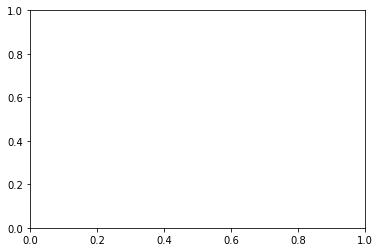

In [20]:
model.eval()
with torch.no_grad():
    function_dist = model(quadrature_times)
    intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
    lower, mean, upper = percentiles_from_samples(intensity_samples)

# Plot the predicted intensity function
fig, ax = plt.subplots(1, 1)
line, = ax.plot(quadrature_times, mean, label=r"Pred $\lambda$")
ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)
ax.plot(quadrature_times, true_intensity_function(quadrature_times), "--", color="k", label=r"True. $\lambda$")
ax.legend(loc="best")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")